# 1. Imports & Setup

In [1]:

import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

## Import Data

In [2]:
raw_reviews = pd.read_csv('./Processed Data/reviews.csv')

In [18]:
purchase_df = pd.read_csv('./Processed Data/games_encoded.csv')
print(purchase_df.head())

    gameid                                              title developers  \
0  3281560         Horror Game To Play With Friends! Playtest        NaN   
1  3280930                            Eternals' Path Playtest        NaN   
2  3280770  ANGST: A TALE OF SURVIVAL - Singleplayer Playtest        NaN   
3  3279790                                   Montabi Playtest        NaN   
4  3278320                                   파이팅걸 유리 Playtest        NaN   

  publishers genres supported_languages release_date genres_cleaned  \
0        NaN    NaN                 NaN   2024-10-21             []   
1        NaN    NaN                 NaN   2024-10-17             []   
2        NaN    NaN                 NaN   2024-10-13             []   
3        NaN    NaN                 NaN   2024-10-13             []   
4        NaN    NaN                 NaN   2024-10-12             []   

   360 Video  Accounting  ...  Simulation  Software Training  Sports  \
0          0           0  ...           0   

In [3]:
print(raw_reviews.head())

   reviewid           playerid  gameid  \
0    639543  76561198796340888     730   
1    639544  76561198028706627  393380   
2    639545  76561198028706627      10   
3    639546  76561198049356580  469600   
4    639547  76561198272817436     730   

                                              review  helpful  funny  awards  \
0  Goud gamę i have 3 vac ban acont but i stilll ...        0      0       0   
1  ---{ Graphics }---☐ You forget what reality is...        0      0       0   
2                       One of the best FPS games :)        0      0       0   
3                  gayet güzel w3 havasını yakalıyor        0      0       0   
4                    ONE OF THE GAMES I COME BACK TO        2      0       0   

       posted  
0  2018-03-22  
1  2025-01-03  
2  2012-05-13  
3  2018-04-21  
4  2020-01-23  


In [50]:
# Load processed data
sentiment_df = pd.read_csv('./Processed Data/sentiment_reviews_18oct.csv')
print(sentiment_df.head())
#print rows
print(sentiment_df.shape)

   reviewid           playerid   gameid  \
0    639544  76561198028706627   393380   
1    639547  76561198272817436      730   
2    639571  76561198111259840  1476680   
3    639583  76561198164012532   244210   
4    639671  76561198979874677   739630   

                                              review  helpful  funny  awards  \
0  ---{ Graphics }---☐ You forget what reality is...        0      0       0   
1                    ONE OF THE GAMES I COME BACK TO        2      0       0   
2  I love this game!Of course it is currently in ...        5      0       1   
3  only purchase if using a sim wheel setup with ...        0      0       0   
4  Fun game and the community is great ive made t...        2      0       0   

       posted language  sentiment_score  
0  2025-01-03       en         5.000000  
1  2020-01-23       en         3.049362  
2  2022-09-23       en         4.779496  
3  2021-09-17       en         4.823064  
4  2020-11-27       en         5.000000  
(303871,

# 2. Sanity Check

## Duplicate Check

Initial check confirmed that there are no duplicate reviews, meaning no single player submitted more than one review for the same game.


In [6]:
# Count the number of reviews per player for each game
review_counts = sentiment_df.groupby(['playerid', 'gameid']).size().reset_index(name='num_reviews')

# Filter to find instances where a player has more than one review (duplicates)
multiple_reviews = review_counts[review_counts['num_reviews'] > 1]

if multiple_reviews.empty:
    print("No instances found where a player gave multiple reviews for the same game.")
else:
    print(multiple_reviews)

No instances found where a player gave multiple reviews for the same game.


## Plotting of sentiment distribution

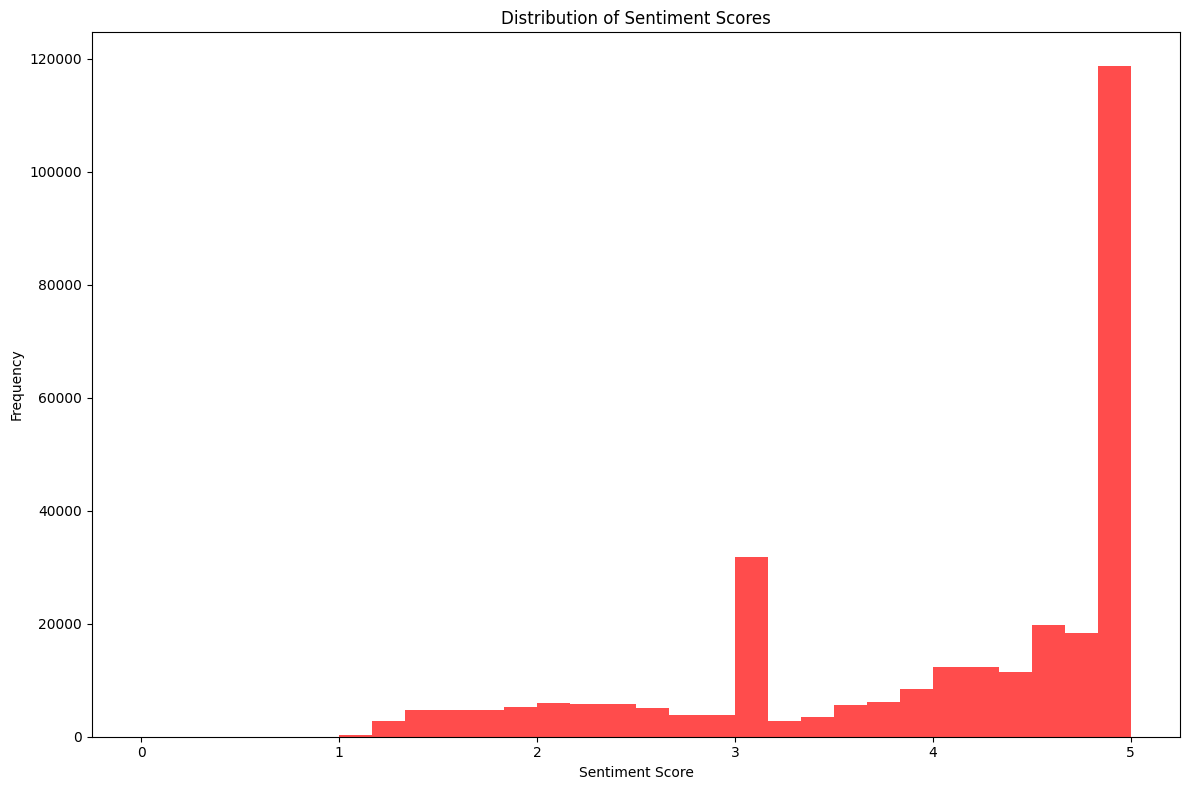

In [7]:
#visualise plot for sentiment_score
plt.figure(figsize=(12, 8))
plt.hist(sentiment_df['sentiment_score'], bins=30, color='red', alpha=0.7)
plt.title('Distribution of Sentiment Scores')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

In [51]:
#drop NA sentiment scores
sentiment_df = sentiment_df.dropna(subset=['sentiment_score'])
#Clip sentiment scores to be within 1.0 to 5.0 then range from 0 to 1
sentiment_df["sentiment_score"] = sentiment_df["sentiment_score"].clip(1.0, 5.0)
sentiment_df["sentiment_score_01"]   = (sentiment_df["sentiment_score"] - 1.0) / 4.0


## Binary Sentiment Distribution
(3.5 rating and above is positive, below is negative)

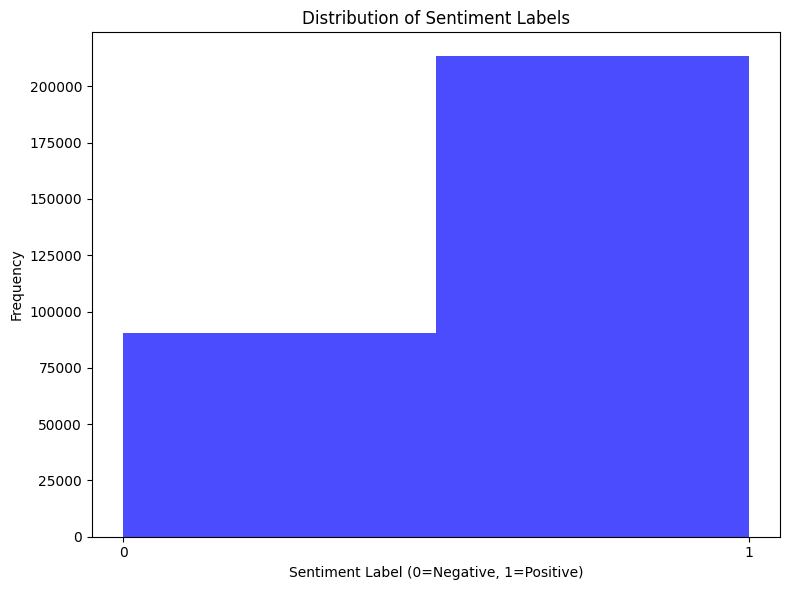

In [21]:
#binarise sentiment_score into positive and negative
sentiment_df['sentiment_label_binary'] = sentiment_df['sentiment_score'].apply(lambda x: 1 if x >= 3.5 else 0)
#visualise plot for sentiment_label
plt.figure(figsize=(8, 6))
plt.hist(sentiment_df['sentiment_label_binary'], bins=2, color='blue', alpha=0.7)
plt.title('Distribution of Sentiment Labels')
plt.xlabel('Sentiment Label (0=Negative, 1=Positive)')
plt.ylabel('Frequency')
plt.xticks([0, 1])
plt.tight_layout()
plt.show()

# 3. Data Preprocessing

Using LabelEncoder to encode userId and gameId and Splitting Data into Train and Test Sets

In [22]:
user_encoder = LabelEncoder()
item_encoder = LabelEncoder()
sentiment_df['player'] = user_encoder.fit_transform(sentiment_df['playerid'])
sentiment_df['game'] = item_encoder.fit_transform(sentiment_df['gameid'])


## Dataset Sparsity () counts-only
U,I = sentiment_df['player'].nunique(), sentiment_df['game'].nunique()
N = len(sentiment_df)
sparsity = 1 - (N / (U * I))


def find_col(df, options):
    for col in df.columns:
        if col in options: return col
    raise ValueError("cannot find column")

#split dataset
train_df, test_df = train_test_split(sentiment_df, test_size=0.2, random_state=4222)


print(f"Players (U): {U}")
print(f"Games (I): {I}")
print(f"Interactions (N): {N}")
print(f"Data Sparsity: {sparsity*100:.2f}%")


Players (U): 65657
Games (I): 28234
Interactions (N): 303871
Data Sparsity: 99.98%


In [23]:
print("Training set length:", len(train_df))
print("Testing set length:", len(test_df))
num_players = sentiment_df['playerid'].nunique()
num_games = sentiment_df['gameid'].nunique()


Training set length: 243096
Testing set length: 60775


In [24]:
class NCFModel(nn.Module):
    def __init__(self, num_players, num_games, embedding_dim=32):
        super(NCFModel, self).__init__()
        self.player_embedding = nn.Embedding(num_players, embedding_dim)
        self.game_embedding = nn.Embedding(num_games, embedding_dim)
        self.fc1 = nn.Linear(embedding_dim * 2, 256)  
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(256, 64)
        self.batchnorm2 = nn.BatchNorm1d(64)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.5)
        self.output_layer = nn.Linear(64, 1)


    def forward(self, player, game):
        player_emb = self.player_embedding(player)
        game_emb = self.game_embedding(game)
        x = torch.cat([player_emb, game_emb], dim=-1)
        x = self.fc1(x)
        x = self.relu1(x)

        x = self.fc2(x)
        x = self.batchnorm2(x)
        x = self.relu2(x)
        x = self.dropout2(x)

        logits = self.output_layer(x)
        return logits


In [43]:
class NCFModel(nn.Module):
    def __init__(self, num_players, num_games, embedding_dim=32, mlp_layers=[256, 64], dropout=0.5):
        super(NCFModel, self).__init__()
        
        # --- GMF (Generalized Matrix Factorization) Pathway ---
        self.gmf_player_embedding = nn.Embedding(num_players, embedding_dim)
        self.gmf_game_embedding = nn.Embedding(num_games, embedding_dim)
        
        # --- MLP (Multi-Layer Perceptron) Pathway ---
        self.mlp_player_embedding = nn.Embedding(num_players, embedding_dim)
        self.mlp_game_embedding = nn.Embedding(num_games, embedding_dim)
        
        # --- MLP Layers ---
        # Your original MLP layers, but made more dynamic
        self.mlp_layers = nn.ModuleList()
        mlp_input_dim = embedding_dim * 2
        
        for layer_dim in mlp_layers:
            self.mlp_layers.append(nn.Linear(mlp_input_dim, layer_dim))
            self.mlp_layers.append(nn.BatchNorm1d(layer_dim)) # Moved BatchNorm before ReLU
            self.mlp_layers.append(nn.ReLU())
            self.mlp_layers.append(nn.Dropout(dropout))
            mlp_input_dim = layer_dim # Next layer's input is this layer's output

        # --- Output Layer ---
        # The final layer's input size is (GMF embedding dim + last MLP layer dim)
        self.output_layer = nn.Linear(embedding_dim + mlp_layers[-1], 1)

    def forward(self, player, game):
        # GMF pathway
        gmf_player_emb = self.gmf_player_embedding(player)
        gmf_game_emb = self.gmf_game_embedding(game)
        gmf_x = gmf_player_emb * gmf_game_emb # Element-wise product
        
        # MLP pathway
        mlp_player_emb = self.mlp_player_embedding(player)
        mlp_game_emb = self.mlp_game_embedding(game)
        mlp_x = torch.cat([mlp_player_emb, mlp_game_emb], dim=-1)
        
        for layer in self.mlp_layers:
            mlp_x = layer(mlp_x)
            
        # Concatenate the GMF and MLP pathways
        x = torch.cat([gmf_x, mlp_x], dim=-1)
        
        # Final output
        logits = self.output_layer(x)
        return logits

In [14]:
class SteamDataset(Dataset):
    def __init__(self, dataframe):
        # Convert columns to tensors
        self.users = torch.tensor(dataframe["player"].values, dtype=torch.long)
        self.items = torch.tensor(dataframe["game"].values, dtype=torch.long)
        self.labels = torch.tensor(dataframe["sentiment_label_binary"].values, dtype=torch.float32)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.users[idx], self.items[idx], self.labels[idx]


train_dataset = SteamDataset(train_df)
test_dataset = SteamDataset(test_df)
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)



Epoch 1 | Train Loss: 0.61019 | Val Loss: 0.60197 | RMSE: 0.45440 | NDCG@10: 0.74408 | Acc: 0.70170
Epoch 2 | Train Loss: 0.59085 | Val Loss: 0.59334 | RMSE: 0.45062 | NDCG@10: 0.74472 | Acc: 0.70208
Epoch 3 | Train Loss: 0.56527 | Val Loss: 0.59780 | RMSE: 0.45112 | NDCG@10: 0.74504 | Acc: 0.70103
Epoch 4 | Train Loss: 0.53720 | Val Loss: 0.60426 | RMSE: 0.45351 | NDCG@10: 0.74459 | Acc: 0.68902
Epoch 5 | Train Loss: 0.50639 | Val Loss: 0.62658 | RMSE: 0.45942 | NDCG@10: 0.74435 | Acc: 0.67603
Epoch 6 | Train Loss: 0.47467 | Val Loss: 0.65146 | RMSE: 0.46542 | NDCG@10: 0.74411 | Acc: 0.66952
Epoch 7 | Train Loss: 0.44354 | Val Loss: 0.67860 | RMSE: 0.47150 | NDCG@10: 0.74373 | Acc: 0.66455
Epoch 8 | Train Loss: 0.41173 | Val Loss: 0.72019 | RMSE: 0.48311 | NDCG@10: 0.74341 | Acc: 0.64471
Epoch 9 | Train Loss: 0.37916 | Val Loss: 0.77939 | RMSE: 0.49186 | NDCG@10: 0.74339 | Acc: 0.64357
Epoch 10 | Train Loss: 0.34930 | Val Loss: 0.82722 | RMSE: 0.50145 | NDCG@10: 0.74310 | Acc: 0.63396

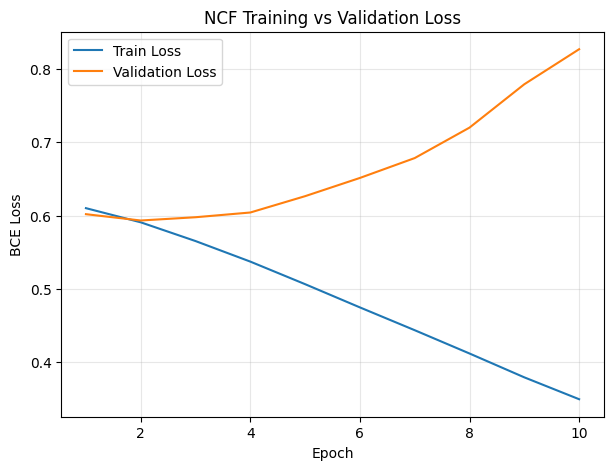

In [15]:

def ndcg_at_k(relevances, k):
    relevances = np.asarray(relevances)[:k]
    if relevances.size == 0:
        return 0.0
    dcg = np.sum((2.0 ** relevances - 1.0) / np.log2(np.arange(2, relevances.size + 2)))
    ideal_relevances = np.sort(relevances)[::-1]
    idcg = np.sum((2.0 ** ideal_relevances - 1.0) / np.log2(np.arange(2, ideal_relevances.size + 2)))
    return float(dcg / idcg) if idcg > 0 else 0.0

model_binary = NCFModel(num_players, num_games, embedding_dim=32)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_binary.to(device)

train_loader_binary = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader_binary  = DataLoader(test_dataset,  batch_size=64, shuffle=False)

# Use logits-aware loss
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model_binary.parameters(), lr=0.001)

num_epochs = 10

# --- Evaluation Function (NDCG@10 + Accuracy) ---
def evaluation_metrics(model, loader, device):
    model.eval()
    all_logits, all_labels, all_users = [], [], []
    total_val_loss, val_batches = 0.0, 0
    with torch.no_grad():
        for users, items, labels in loader:
            users  = users.to(device)
            items  = items.to(device)
            labels = labels.to(device).float()  

            logits = model(users, items).squeeze(1)       
            loss   = criterion(logits, labels)
            total_val_loss += loss.item()
            val_batches += 1

            all_logits.append(logits.cpu().numpy())
            all_labels.append(labels.cpu().numpy())
            all_users.append(users.cpu().numpy())

    logits = np.concatenate(all_logits)
    labels = np.concatenate(all_labels)
    users  = np.concatenate(all_users)

    # probabilities for metrics
    probs = 1.0 / (1.0 + np.exp(-logits))

    # RMSE (Brier-style)
    rmse = float(np.sqrt(np.mean((probs - labels) ** 2)))

    # NDCG@10 (per-user)
    ndcgs = []
    user_to_idx = {}
    for i, u in enumerate(users):
        uid = int(u)
        user_to_idx.setdefault(uid, []).append(i)

    for u, idxs in user_to_idx.items():
        scores_u = probs[idxs]
        labels_u = labels[idxs]
        order = np.argsort(-scores_u)          
        ranked_relevances = labels_u[order]    
        ndcgs.append(ndcg_at_k(ranked_relevances, 10))

    ndcg10 = float(np.mean(ndcgs)) if len(ndcgs) > 0 else 0.0

    # Accuracy (binary threshold at 0.5)
    preds_binary  = (probs >= 0.5).astype(int)
    labels_binary = (labels >= 0.5).astype(int)
    accuracy = float(np.mean(preds_binary == labels_binary))

    avg_val_loss = total_val_loss / val_batches if val_batches > 0 else 0.0
    return avg_val_loss, rmse, ndcg10, accuracy

train_losses, val_losses = [], []

for epoch in range(1, num_epochs + 1):
    model_binary.train()
    running_loss, num_batches = 0.0, 0

    for users, items, labels in train_loader_binary:
        users  = users.to(device)
        items  = items.to(device)
        labels = labels.to(device).float()  

        optimizer.zero_grad()
        logits = model_binary(users, items).squeeze(1)  
        loss = criterion(logits, labels)                 
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        num_batches += 1

    avg_train_loss = running_loss / max(num_batches, 1)
    train_losses.append(avg_train_loss)

    # eval
    avg_val_loss, rmse, ndcg10, acc = evaluation_metrics(model_binary, test_loader_binary, device)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch} | Train Loss: {avg_train_loss:.5f} | "
          f"Val Loss: {avg_val_loss:.5f} | RMSE: {rmse:.5f} | "
          f"NDCG@10: {ndcg10:.5f} | Acc: {acc:.5f}")

plt.figure(figsize=(7,5))
plt.plot(range(1, num_epochs + 1), train_losses, label="Train Loss")
plt.plot(range(1, num_epochs + 1), val_losses,  label="Validation Loss")
plt.title("NCF Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("BCE Loss")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()




In [40]:
class SteamDatasetNonBinary(Dataset):
    def __init__(self, dataframe):
        # Convert columns to tensors
        self.users = torch.tensor(dataframe["player"].values, dtype=torch.long)
        self.items = torch.tensor(dataframe["game"].values, dtype=torch.long)
        #utilised 1to5 sentiment labels
        self.labels = torch.tensor(dataframe["sentiment_score_01"].values, dtype=torch.float32)

    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return self.users[idx], self.items[idx], self.labels[idx]


train_dataset = SteamDatasetNonBinary(train_df)
test_dataset = SteamDatasetNonBinary(test_df)
train_loader_nonbinary = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader_nonbinary = DataLoader(test_dataset, batch_size=128, shuffle=False)



Epoch 1 | Train Loss: 0.09454 | Val Loss: 0.07464 | RMSE: 0.27319 | NDCG@10: 0.97669 | MAE: 0.23764
Epoch 2 | Train Loss: 0.07316 | Val Loss: 0.07097 | RMSE: 0.26639 | NDCG@10: 0.97808 | MAE: 0.22415
Epoch 3 | Train Loss: 0.07028 | Val Loss: 0.07008 | RMSE: 0.26471 | NDCG@10: 0.97850 | MAE: 0.21863
Epoch 4 | Train Loss: 0.06792 | Val Loss: 0.07030 | RMSE: 0.26514 | NDCG@10: 0.97859 | MAE: 0.22245
Epoch 5 | Train Loss: 0.06516 | Val Loss: 0.07062 | RMSE: 0.26574 | NDCG@10: 0.97861 | MAE: 0.21658
Epoch 6 | Train Loss: 0.06298 | Val Loss: 0.07074 | RMSE: 0.26596 | NDCG@10: 0.97829 | MAE: 0.22465
Epoch 7 | Train Loss: 0.05470 | Val Loss: 0.07462 | RMSE: 0.27316 | NDCG@10: 0.97827 | MAE: 0.21674
Epoch 8 | Train Loss: 0.05166 | Val Loss: 0.07501 | RMSE: 0.27387 | NDCG@10: 0.97803 | MAE: 0.21593
Epoch 9 | Train Loss: 0.04948 | Val Loss: 0.07664 | RMSE: 0.27684 | NDCG@10: 0.97770 | MAE: 0.21659
Epoch 10 | Train Loss: 0.04613 | Val Loss: 0.07766 | RMSE: 0.27867 | NDCG@10: 0.97766 | MAE: 0.21676

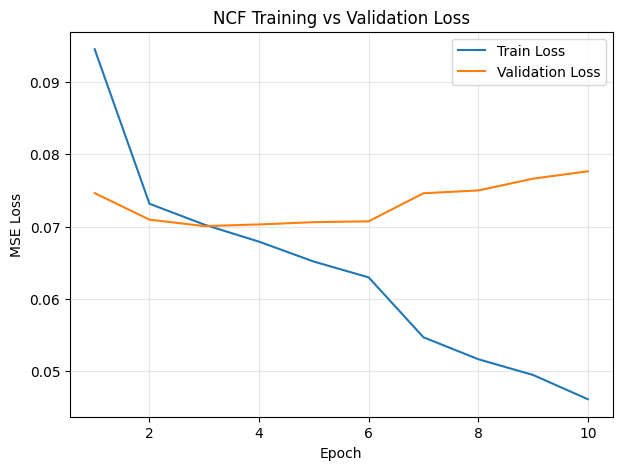

In [ ]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
def ndcg_at_k(relevances, k):
    relevances = np.asarray(relevances)[:k]
    if relevances.size == 0:
        return 0.0
    dcg = np.sum((2 ** relevances - 1) / np.log2(np.arange(2, relevances.size + 2)))
    ideal_relevances = np.sort(relevances)[::-1]
    idcg = np.sum((2 ** ideal_relevances - 1) / np.log2(np.arange(2, ideal_relevances.size + 2)))
    return dcg / idcg if idcg > 0 else 0.0

model = NCFModel(num_players, num_games, embedding_dim=32, mlp_layers=[256, 64], dropout=0.5)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimiser = optim.Adam(model.parameters(), lr=0.002, weight_decay=1e-5)
criterion = nn.MSELoss()
scheduler = ReduceLROnPlateau(optimiser, mode='min', factor=0.1, patience=2)
EPOCHS = 10

def evaluation_metrics(model, loader, device):
    model.eval()
    all_preds, all_labels, all_users = [], [], []
    total_val_loss, val_batches = 0.0, 0
    with torch.no_grad():
        for users, items, labels in loader:
            users = users.to(device)
            items = items.to(device)
            labels = labels.to(device)

            preds = model(users, items).squeeze(1)
            loss = criterion(preds, labels)
            total_val_loss += loss.item()
            val_batches += 1

            all_preds.append(preds.cpu().numpy())
            all_labels.append(labels.cpu().numpy())
            all_users.append(users.cpu().numpy())

    preds = np.concatenate(all_preds)
    labels = np.concatenate(all_labels)
    users = np.concatenate(all_users)

    rmse = np.sqrt(np.mean((preds - labels) ** 2))


    ndcgs = []
    user_to_idx = {}
    for i, u in enumerate(users):
        if int(u) not in user_to_idx:
            user_to_idx[int(u)] = []
        user_to_idx[int(u)].append(i)

    for u, idxs in user_to_idx.items():
        scores_u = preds[idxs]
        labels_u = labels[idxs]
        order = np.argsort(-scores_u)  
        ranked_relevances = labels_u[order]
        ndcgs.append(ndcg_at_k(ranked_relevances, 10))

    ndcg10 = float(np.mean(ndcgs)) if len(ndcgs) > 0 else 0.0

    # Mean Absolute Error
    mae = np.mean(np.abs(preds - labels))

    avg_val_loss = total_val_loss / val_batches if val_batches > 0 else 0.0
    return avg_val_loss, rmse, ndcg10, mae


train_losses = []
val_losses = []

for epoch in range(1, EPOCHS + 1):
    model.train()
    running_train_loss, train_batches = 0.0, 0

    for users, items, labels in train_loader_nonbinary:
        users = users.to(device)
        items = items.to(device)
        labels = labels.to(device)

        optimiser.zero_grad()
        preds = model(users, items).squeeze(1)
        loss = criterion(preds, labels)
        loss.backward()
        optimiser.step()

        running_train_loss += loss.item()
        train_batches += 1

    avg_train_loss = running_train_loss / max(train_batches, 1)
    train_losses.append(avg_train_loss)

    #eval
    val_loss, rmse, ndcg10, mae = evaluation_metrics(model, test_loader_nonbinary, device)
    val_losses.append(val_loss)
    scheduler.step(val_loss)

    print(f"Epoch {epoch} | "
          f"Train Loss: {avg_train_loss:.5f} | "
          f"Val Loss: {val_loss:.5f} | "
          f"RMSE: {rmse:.5f} | "
          f"NDCG@10: {ndcg10:.5f} | "
          f"MAE: {mae:.5f}")

plt.figure(figsize=(7,5))
plt.plot(range(1, EPOCHS + 1), train_losses, label="Train Loss")
plt.plot(range(1, EPOCHS + 1), val_losses, label="Validation Loss")
plt.title("NCF Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

#get precision at k function
def precision_at_k(relevances, k):
    relevances = np.asarray(relevances)[:k]
    if relevances.size == 0:
        return 0.0
    return np.sum(relevances) / k
#get recall at k function
def recall_at_k(relevances, k):
    relevances = np.asarray(relevances)[:k]
    if relevances.size == 0:
        return 0.0
    return np.sum(relevances) / np.sum(relevances)  # Total relevant items in the dataset
#get confusion matrix function
from sklearn.metrics import confusion_matrix
def compute_confusion_matrix(y_true, y_pred):
    return confusion_matrix(y_true, y_pred)

